In [2]:
import pickle

with open('data/curvature/point_clouds.pkl', 'rb') as f:
    data = pickle.load(f)
with open('data/curvature/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('data/curvature/train_indices.pkl', 'rb') as f:
    train_indices = pickle.load(f)
with open('data/curvature/test_indices.pkl', 'rb') as f:
    test_indices = pickle.load(f)

In [3]:
print(len(data))
print(len(labels))
print(len(train_indices))
print(len(test_indices))
# print(type(data))
# print(type(train_indices))

1110
1110
1010
100


In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold

from PLDiv import compute_PLDiv

import time

In [5]:
start_time = time.time() 

pldiv_1 = np.array([
    compute_PLDiv(d, hom_deg=0, sparse=None, closed_form=False)   # without sparse matrix optimization
    for d in data
])

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 77.199 seconds


In [6]:
start_time = time.time() 

pldiv_2 = np.array([
    compute_PLDiv(d, hom_deg=0, sparse=0.3, closed_form=False)   # with sparse matrix optimization, sparsity=0.3
    for d in data
])

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 45.567 seconds


In [8]:
start_time = time.time() 

pldiv_3 = np.array([
    compute_PLDiv(d, hom_deg=0, sparse=0.3, closed_form=True)   # sparse matrix optimization + closed form
    for d in data
])

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 8.232 seconds


VS, DCScore, MagArea

In [9]:
start_time = time.time() 

from magnipy.diversipy import Diversipy
div = Diversipy(Xs = data,  ref_space=0)
mag_areas = div.MagAreas()

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

Runtime: 1010.576 seconds


In [10]:
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from vendi_score import vendi
import torch

In [11]:
start_time = time.time() 

sim_rbf = [rbf_kernel(d, gamma=0.5) for d in data]
print(len(sim_rbf))
vs_rbf = [vendi.score_K(K) for K in sim_rbf]
print(len(vs_rbf))

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

1110
1110
Runtime: 48.110 seconds


In [33]:
vs_rbf = [vendi.score_K(K) for K in sim_rbf]

In [20]:
start_time = time.time() 

sim_l1 = [laplacian_kernel(d, gamma = 1.0) for d in data]
print(len(sim_l1))
vs_l1 = [vendi.score_K(K) for K in sim_l1]
print(len(vs_l1))

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

1110
1110
Runtime: 29.845 seconds


In [34]:
vs_l1 = [vendi.score_K(K) for K in sim_l1]

In [25]:
def dcscore (sim_product):
    sim_product = torch.from_numpy(sim_product)
    sim_probs = sim_product.softmax(dim=-1)
    diversity = torch.sum(torch.diag(sim_probs))
    return diversity.item()

In [26]:
start_time = time.time() 

sim_rbf = [rbf_kernel(d, gamma=0.5) for d in data]
print(len(sim_rbf))
dcs_rbf = [dcscore(K) for K in sim_rbf]
print(len(dcs_rbf))

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

1110
1110
Runtime: 18.710 seconds


In [28]:
dcs_rbf = [dcscore(K) for K in sim_rbf]

In [31]:
start_time = time.time() 

sim_l1 = [laplacian_kernel(d, gamma = 1.0) for d in data]
print(len(sim_l1))
dcs_l1 = [dcscore(K) for K in sim_l1]
print(len(dcs_l1))

end_time = time.time() 
print(f"Runtime: {end_time - start_time:.3f} seconds")

1110
1110
Runtime: 3.536 seconds


In [32]:
dcs_l1 = [dcscore(K) for K in sim_l1]

Modeling

In [35]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, pldiv_1.reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.03868867 -0.0408124  -0.04102203 -0.03774953 -0.04098535]
Average MSE: -0.03985159597863592
Standard deviation of MSE: 0.0013674423962373686


In [36]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, pldiv_2.reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.0389502  -0.04075458 -0.04153638 -0.03783321 -0.04074742]
Average MSE: -0.0399643593165932
Standard deviation of MSE: 0.0013622913933361456


In [37]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, pldiv_3.reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.03907862 -0.04053104 -0.04140772 -0.03800065 -0.04072026]
Average MSE: -0.039947659865159545
Standard deviation of MSE: 0.0012341077612351848


In [38]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, np.array(mag_areas).reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.10920355 -0.12534575 -0.10679625 -0.12808041 -0.13228598]
Average MSE: -0.1203423883592832
Standard deviation of MSE: 0.010345351940635846


In [39]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, np.array(vs_rbf).reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.05292764 -0.05830297 -0.05462608 -0.0474732  -0.05413747]
Average MSE: -0.05349347137576743
Standard deviation of MSE: 0.0035040706517654287


In [40]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, np.array(vs_l1).reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.24243746 -0.26766744 -0.21067839 -0.15777909 -0.26827833]
Average MSE: -0.2293681419725476
Standard deviation of MSE: 0.04153539613110977


In [41]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, np.array(dcs_rbf).reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.05155097 -0.05858006 -0.05153293 -0.0459817  -0.05266716]
Average MSE: -0.0520625655501231
Standard deviation of MSE: 0.0040090489766300185


In [42]:
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm, np.array(dcs_l1).reshape(-1, 1), labels, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("Cross-validation MSE:", cv_scores)
print("Average MSE:", np.mean(cv_scores))
print("Standard deviation of MSE:", np.std(cv_scores))

Cross-validation MSE: [-0.13479124 -0.15544134 -0.12712732 -0.10185068 -0.14907863]
Average MSE: -0.1336578393006845
Standard deviation of MSE: 0.018803985631762225


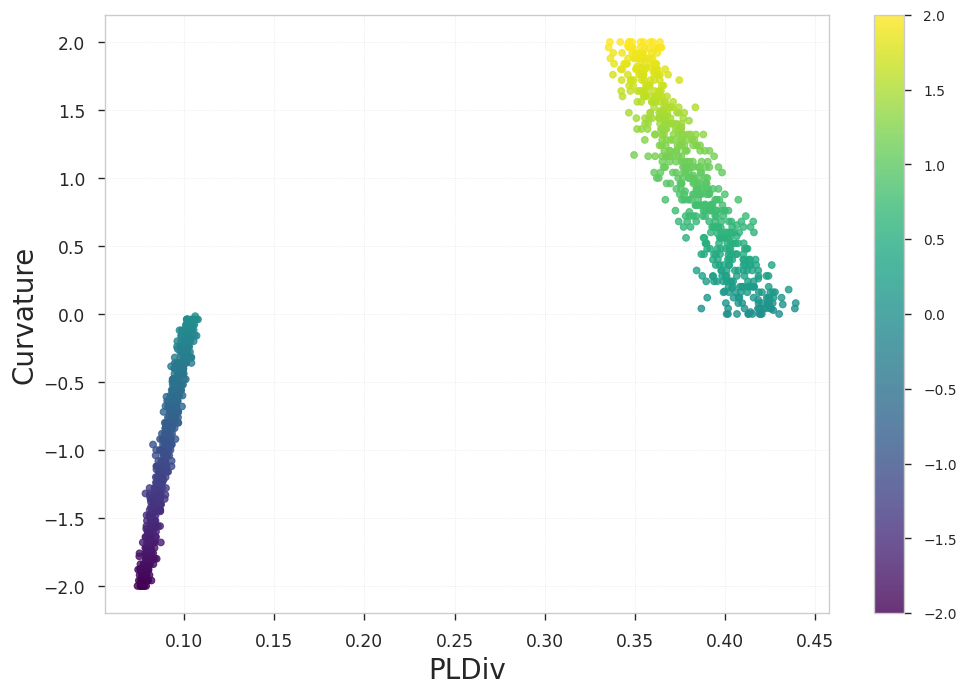

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use a professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.4)
sns.set_palette("deep")

# 2. Create the scatter plot
# 'cmap' set to 'coolwarm' for a more professional diverging color palette
# scatter = plt.scatter(pldiv_1, labels, c=labels, cmap='coolwarm', s=10, edgecolor='k', linewidth=0.5, alpha=0.8)

scatter = plt.scatter(pldiv_1,  labels, c = labels, cmap='viridis', alpha=0.8)
# 3. Add and label the color bar
cbar = plt.colorbar(scatter)
# cbar.set_label('Curvature Value', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# 4. Add labels and a title to the plot
plt.xlabel("PLDiv", fontsize=20)
plt.ylabel("Curvature", fontsize=20)
# plt.title("Curvature vs. PLDiv", fontsize=15, pad=10)

# 5. Refine grid and layout
plt.grid(True, linestyle=':', linewidth=0.6, alpha=0.5)
plt.tight_layout()

# 6. Save high-res figure for paper
plt.savefig("curature.png", dpi=300, bbox_inches='tight')
plt.show()
